In [ ]:
!pip install ultralytics

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
!cp -r "/content/drive/MyDrive/S3/Dataset/Dataset Retail 70-30.zip" "/content/"

In [ ]:
!unzip "/content/Dataset Retail 70-30.zip" -d "/content/"

In [ ]:
from ultralytics import YOLO

In [ ]:
model = YOLO('yolov8m-pose.pt')

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.version.cuda)
print(torch.backends.cudnn.version())

In [12]:
model = YOLO("yolo11m-pose.pt")

## Extract keypoint from 1 image

In [45]:
# Predict with the model
results = model("/content/Dataset/val/images/Touching (3834).jpg")


image 1/1 /content/Dataset Retail 70-30/val/images/Touching (3834).jpg: 384x640 1 person, 34.0ms
Speed: 4.8ms preprocess, 34.0ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)


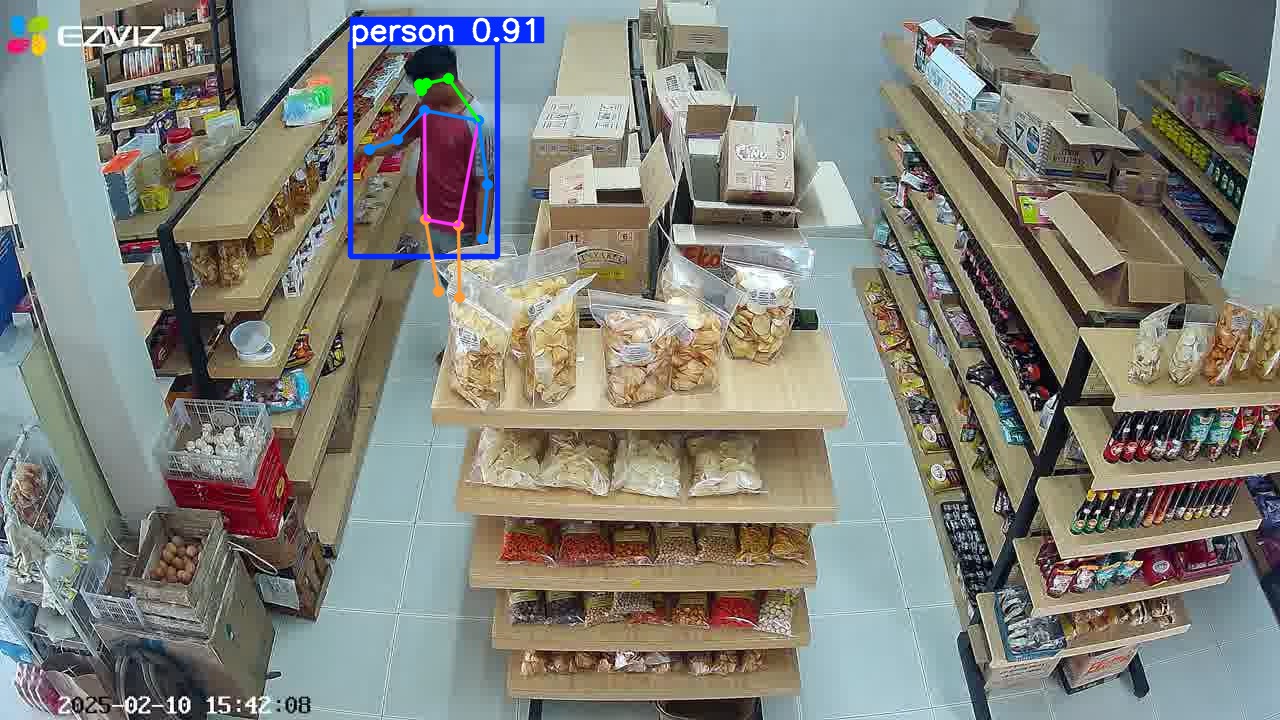

In [46]:
from PIL import Image

# Show the results as an image
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    display(im)

In [21]:
import pandas as pd

# COCO keypoint names for pose estimation
keypoint_names = [
    'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee',
    'right_knee', 'left_ankle', 'right_ankle'
]

keypoints_list = []

for r in results:
    if hasattr(r, 'keypoints') and r.keypoints is not None:
        # Extract keypoints for each detected instance
        for instance_id, keypoints_data in enumerate(r.keypoints.data):
            instance_keypoints = {'instance_id': instance_id}
            for i, kp in enumerate(keypoints_data):
                if i < len(keypoint_names):
                    keypoint_name = keypoint_names[i]
                    instance_keypoints[f'{keypoint_name}_x'] = kp[0].item()
                    instance_keypoints[f'{keypoint_name}_y'] = kp[1].item()
                    # Add confidence if available
                    if len(kp) > 2:
                        instance_keypoints[f'{keypoint_name}_confidence'] = kp[2].item()
                else:
                    # Fallback for keypoints beyond the named ones
                    instance_keypoints[f'keypoint_{i}_x'] = kp[0].item()
                    instance_keypoints[f'keypoint_{i}_y'] = kp[1].item()
                    if len(kp) > 2:
                        instance_keypoints[f'keypoint_{i}_confidence'] = kp[2].item()

            keypoints_list.append(instance_keypoints)

# Create a pandas DataFrame from the extracted keypoints
keypoints_df = pd.DataFrame(keypoints_list)

# Display the DataFrame
display(keypoints_df)

,instance_id,nose_x,nose_y,nose_confidence,left_eye_x,left_eye_y,left_eye_confidence,right_eye_x,right_eye_y,right_eye_confidence,...,left_knee_confidence,right_knee_x,right_knee_y,right_knee_confidence,left_ankle_x,left_ankle_y,left_ankle_confidence,right_ankle_x,right_ankle_y,right_ankle_confidence
0,0,792.290283,432.279419,0.134798,792.572754,424.737701,0.147013,792.606567,421.557861,0.029626,...,0.665283,762.610107,745.236023,0.423759,724.613464,845.788025,0.493829,724.228455,847.007812,0.346133
1,1,142.933609,444.481781,0.955113,148.861237,436.248627,0.717408,133.377518,435.188934,0.949038,...,0.966528,91.603668,747.742310,0.981776,177.139938,857.923096,0.889772,77.184601,859.770752,0.917627
2,2,294.583862,448.148865,0.996145,300.885803,440.125305,0.957738,284.228271,440.784485,0.995991,...,0.999646,261.354187,723.069519,0.999634,273.414307,781.266541,0.997325,270.018250,812.135864,0.996936
3,3,6.040406,514.956238,0.064353,5.206889,503.331909,0.013957,4.903724,503.059875,0.063319,...,0.028003,1.761229,826.855164,0.205736,4.693850,945.678833,0.011526,7.131034,956.134583,0.059476


## Extract keypoint from all images

Read the class names from the `data.yaml` file.


In [22]:
import yaml

yaml_file_path = '/content/data.yaml'

with open(yaml_file_path, 'r') as file:
    data = yaml.safe_load(file)

class_names = data.get('names', [])

print(class_names)

['No Interest', 'Viewing', 'Turning to Shelf', 'Touching', 'Picking and Returning', 'Picking and Putting']


List all image files in the dataset directory.


In [ ]:
import os

data_dir = '/content/Dataset/'
image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(image_files[:5])

In [24]:
print(os.listdir(data_dir))

['images', 'labels']


In [25]:
data_images_dir = '/content/Dataset/images'
image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(image_files[:5])

['Picking and Putting (11412).jpg', 'Touching (11263).jpg', 'Picking and Returning (11650).jpg', 'Turning_to_Shelf (2155).jpg', 'Turning_to_Shelf (1505).jpg']


## Iterate and predict



In [ ]:
all_keypoints_data = []

for image_file in image_files:
    image_path = os.path.join(train_images_dir, image_file)
    results = model(image_path)

    for r in results:
        if hasattr(r, 'keypoints') and r.keypoints is not None:
            if hasattr(r, 'boxes') and r.boxes is not None:
                for instance_id, keypoints_data in enumerate(r.keypoints.data):
                    instance_info = {
                        'image_path': image_path,
                        'instance_id': instance_id
                    }

                    # Get class name
                    if instance_id < len(r.boxes.cls):
                        class_id = int(r.boxes.cls[instance_id].item())
                        if class_id < len(class_names):
                            instance_info['class_name'] = class_names[class_id]
                        else:
                            instance_info['class_name'] = f'unknown_class_{class_id}'
                    else:
                         instance_info['class_name'] = 'no_class_detected'


                    # Extract keypoints
                    for i, kp in enumerate(keypoints_data):
                        if i < len(keypoint_names):
                            keypoint_name = keypoint_names[i]
                            instance_info[f'{keypoint_name}_x'] = kp[0].item()
                            instance_info[f'{keypoint_name}_y'] = kp[1].item()
                            if len(kp) > 2:
                                instance_info[f'{keypoint_name}_confidence'] = kp[2].item()
                        else:
                            instance_info[f'keypoint_{i}_x'] = kp[0].item()
                            instance_info[f'keypoint_{i}_y'] = kp[1].item()
                            if len(kp) > 2:
                                instance_info[f'keypoint_{i}_confidence'] = kp[2].item()

                    all_keypoints_data.append(instance_info)


## Create DataFrame


In [27]:
keypoints_df_all = pd.DataFrame(all_keypoints_data)

## Display or save


In [ ]:
display(keypoints_df_all.head())

In [30]:
keypoints_df_all.to_csv('all_image_keypoints_with_class.csv', index=False)

In [35]:
keypoints_df_val.to_csv('validation_image_keypoints_with_class.csv', index=False)

## Classificiation using SVM, DNN, MLP and Random Forest

SVM

In [ ]:
# --- 1. Install dan Import Library ---
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report


from google.colab import files
uploaded = files.upload()  # Upload file

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

def extract_class_from_path(path):
    filename = path.split("/")[-1]
    class_part = re.split(r'\s*\(', filename)[0]
    return class_part.replace("_", " ").strip()

df["class_name"] = df["image_path"].apply(extract_class_from_path)

X = df.drop(columns=["image_path", "instance_id", "class_name"])
y = df["class_name"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 5. Splitting Data: 70% Train, 20% Validasi, 10% Test ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

# ---SVM ---
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_val_pred = svm_model.predict(X_val)
val_report = classification_report(y_val, y_val_pred, target_names=label_encoder.classes_)
print("=== Classification Report (Validation Set) ===")
print(val_report)

y_test_pred = svm_model.predict(X_test)
test_report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_)
print("=== Classification Report (Test Set) ===")
print(test_report)


DNN, MLP and Random Forest

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam


from google.colab import files
uploaded = files.upload()  # Upload file

filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)

def extract_class_from_path(path):
    filename = path.split("/")[-1]
    class_part = re.split(r'\s*\(', filename)[0]
    return class_part.replace("_", " ").strip()

df["class_name"] = df["image_path"].apply(extract_class_from_path)

X = df.drop(columns=["image_path", "instance_id", "class_name"])
y = df["class_name"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

# DNN
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# --- Deep Neural Network (Keras) ---
dnn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train_cat.shape[1], activation='softmax')
])
dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
dnn_model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=20, batch_size=64, verbose=0)

dnn_val_pred = np.argmax(dnn_model.predict(X_val), axis=1)
dnn_test_pred = np.argmax(dnn_model.predict(X_test), axis=1)

print("=== Deep Neural Network (DNN) ===")
print("Validation Accuracy:", accuracy_score(y_val, dnn_val_pred))
print("Test Accuracy:", accuracy_score(y_test, dnn_test_pred))
print("\n[Validation Report]\n", classification_report(y_val, dnn_val_pred, target_names=label_encoder.classes_))
print("\n[Test Report]\n", classification_report(y_test, dnn_test_pred, target_names=label_encoder.classes_))

# --- Multilayer Perceptron (sklearn) ---
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=200, random_state=42)
mlp.fit(X_train, y_train)

mlp_val_pred = mlp.predict(X_val)
mlp_test_pred = mlp.predict(X_test)

print("\n=== Multilayer Perceptron (MLP) ===")
print("Validation Accuracy:", accuracy_score(y_val, mlp_val_pred))
print("Test Accuracy:", accuracy_score(y_test, mlp_test_pred))
print("\n[Validation Report]\n", classification_report(y_val, mlp_val_pred, target_names=label_encoder.classes_))
print("\n[Test Report]\n", classification_report(y_test, mlp_test_pred, target_names=label_encoder.classes_))

# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_val_pred = rf.predict(X_val)
rf_test_pred = rf.predict(X_test)

print("\n=== Random Forest ===")
print("Validation Accuracy:", accuracy_score(y_val, rf_val_pred))
print("Test Accuracy:", accuracy_score(y_test, rf_test_pred))
print("\n[Validation Report]\n", classification_report(y_val, rf_val_pred, target_names=label_encoder.classes_))
print("\n[Test Report]\n", classification_report(y_test, rf_test_pred, target_names=label_encoder.classes_))
